# Alignment

I want to explore configurations of the met20 section, to do that i can align the traj on the backbone excluding met2, then i can run rmsd, rmsf (just to see possible differences) and rog

In [1]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
data_path = "../../data_3eig/02_processed/02_npt/"
sel = 'name CA'
sel_alignment = 'name CA and resid 25:300'


#concatenation 

traj_0 = data_path + "prod_0/step5_prod_0_nbc.xtc"
traj_1 = data_path + "prod_1/step5_prod_1_nbc.xtc"
traj_2 = data_path + "prod_2/step5_prod_2_nbc.xtc"
traj_3 = data_path + "prod_3/step5_prod_3_nbc.xtc"


config_file = data_path + "step5_prod_0.tpr"
concat_traj_file = data_path + "prod_cat_barMet20.xtc"

# aligner and concatenation is heavy to run, if it has already been run it can be turned off by setting 'already_done' to False -GM
already_done = True
if not already_done: 
    conc_traj = mda.Universe(config_file, [traj_0,traj_1, traj_2, traj_3])
    ref_traj = mda.Universe(config_file, traj_0)
    
    ref_traj.trajectory[0]
    aligner = AlignTraj(conc_traj,ref_traj,select=sel_alignment,filename = concat_traj_file)
    aligner.run()

In [5]:
aligned_traj = mda.Universe(config_file, concat_traj_file)

Text(0, 0.5, 'RMSD')

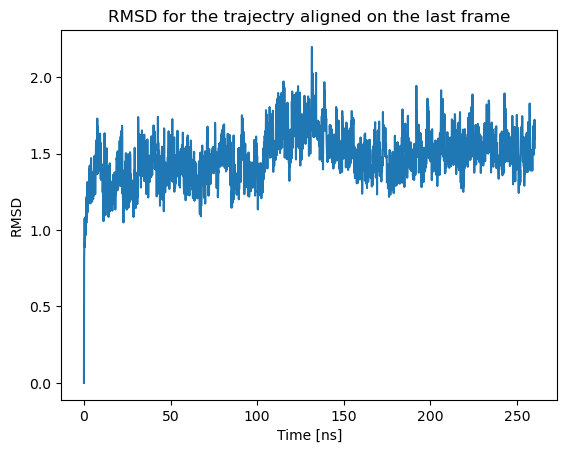

In [6]:
R = RMSD(aligned_traj, ref_traj, select=sel).run()

plt.title("RMSD for the trajectry aligned on the last frame")
plt.plot(R.results.rmsd[:,0] / 10, R.results.rmsd[:,2])
plt.xlabel('Time [ns]')
plt.ylabel('RMSD')

Text(0, 0.5, 'RMSF')

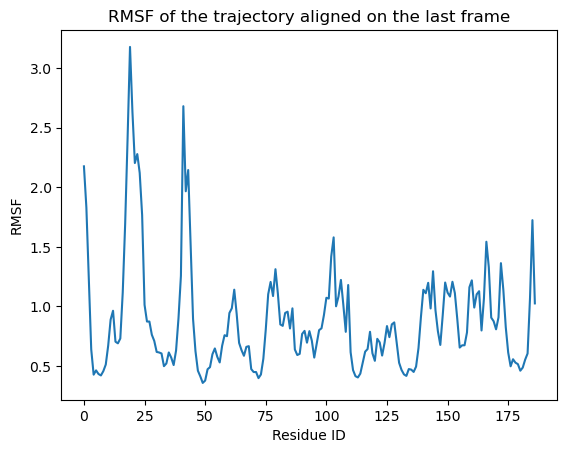

In [7]:
RF = RMSF(aligned_traj.select_atoms(sel)).run()

plt.title('RMSF of the trajectory aligned on the last frame')
plt.plot(RF.results.rmsf)
plt.xlabel('Residue ID')
plt.ylabel('RMSF')

Text(0, 0.5, 'Radius of Gyration')

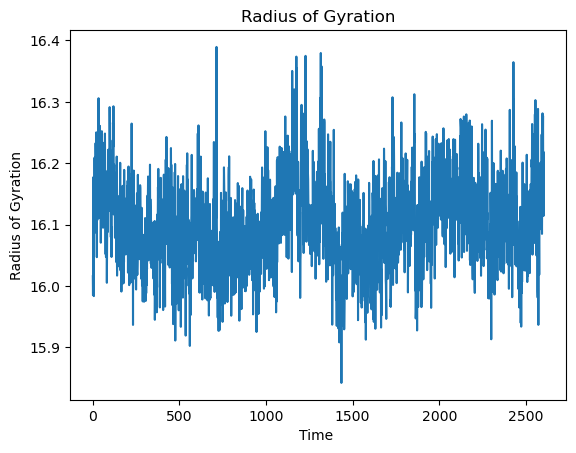

In [8]:
atom_group = aligned_traj.select_atoms(sel)

radii_o_gyr = []

for ts in aligned_traj.trajectory:
    rg = atom_group.radius_of_gyration()
    radii_o_gyr.append(rg)

plt.title('Radius of Gyration')
plt.plot(radii_o_gyr)
plt.xlabel('Time ')
plt.ylabel('Radius of Gyration')

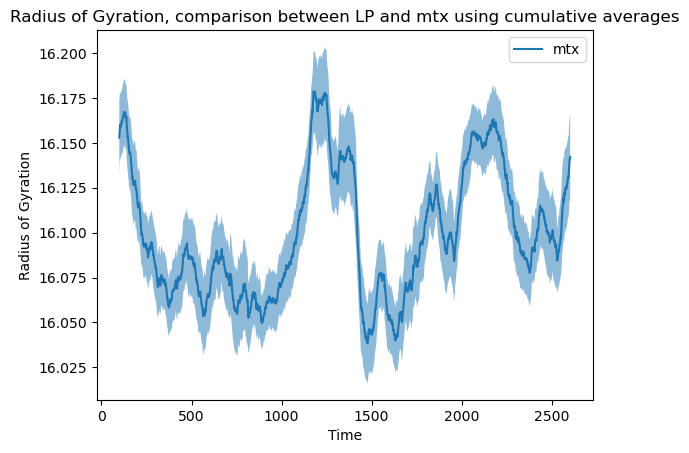

In [9]:
rg_mtx_df = pd.DataFrame({"rgyr": radii_o_gyr})

err_MTX = np.sqrt(rg_mtx_df.rolling(100).var()["rgyr"] / 10)
mean_MTX = rg_mtx_df.rolling(100).mean()["rgyr"] 
plt.title('Radius of Gyration, comparison between LP and mtx using cumulative averages')
plt.plot(mean_MTX, label = "mtx")
plt.fill_between(rg_mtx_df.index, mean_MTX - err_MTX, mean_MTX + err_MTX, alpha = 0.5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Radius of Gyration')
plt.show()